In [6]:
!pip install mat4py
!pip install imblearn

In [1]:
import sklearn as sk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import scipy.io as sio
from mat4py import loadmat 
import time
import glob
from sklearn.model_selection import train_test_split
from scipy.signal import welch, freqz, butter, filtfilt

from sklearn.model_selection import cross_val_predict, TimeSeriesSplit
import seaborn as sns

# from pyriemann.estimation import Covariances
# from pyriemann.tangentspace import TangentSpace

import warnings
warnings.filterwarnings('ignore')

from mne.decoding import Vectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, CategoricalNB, ComplementNB

from mne import (io, compute_raw_covariance, read_events, pick_types, Epochs)
from mne.preprocessing import Xdawn
from mne.viz import plot_epochs_image
import mne
mne.set_log_level('WARNING')

from sklearn.pipeline import make_pipeline

import os

In [2]:
folder = '../p300samplingdataset/*.mat'
files = glob.glob(folder)
print(len(files), files)
# files.pop(0) #drop the data badly structured
# test_file = files.pop(0) #last subject for testing the network
print(len(files))

channels = ['Fz', 'Cz', 'P3', 'Pz', 'P4', 'PO7', 'PO8', 'Oz']

8 ['../p300samplingdataset/P300S02.mat', '../p300samplingdataset/P300S04.mat', '../p300samplingdataset/P300S06.mat', '../p300samplingdataset/P300S08.mat', '../p300samplingdataset/P300S07.mat', '../p300samplingdataset/P300S01.mat', '../p300samplingdataset/P300S05.mat', '../p300samplingdataset/P300S03.mat']
8


In [3]:
def load_data(file):
    raw_data = loadmat(file)
    useful_data = raw_data['data'].copy()
    X = useful_data['X']
    Y = useful_data['y']
    T = useful_data['trial']
    F = useful_data['flash']
    
    return X, Y, T, F

In [4]:
# For filtering the data
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y


In [8]:
from imblearn.under_sampling import RandomUnderSampler

# Cut the data into trials
def prepare_data(X, Y, flash, start, stop, filter_boo):
    X = np.array(X)
    
    if filter_boo:
        X = butter_bandpass_filter(X.T, low, high, fs).T
    
    start_samples = int(start*fs)
    stop_samples = int(stop*fs)
    
    X_samples = np.zeros((len(flash)-120, int(stop_samples-start_samples), 8))

    for i in range(len(flash)-120):
        event = flash[i][0]
        X_samples[i, :, :] = X[event+start_samples:event+stop_samples :]
    label     = [i[3] - 1 for i in flash]

    LIMIT = 4080 #the last trial is incomplete
    y = np.array(label[:LIMIT])
    X_samples = X_samples.reshape(X_samples.shape[0], X_samples.shape[1] * X_samples.shape[2])
    
    undersample = RandomUnderSampler(sampling_strategy='majority')
    X_under, y_under = undersample.fit_resample(X_samples, y)
    
#     print(X_under.shape, y_under.shape)
#     print(sum(y_under))
    
    return X_under, y_under


def prepare_data_nonUS(X, Y, flash, start, stop):
    X = np.array(X)
    
    start_samples = int(start*fs)
    stop_samples = int(stop*fs)
    
    X_samples = np.zeros((len(flash)-120, int(stop_samples-start_samples), 8))

    for i in range(len(flash)-120):
        event = flash[i][0] # should have 4080 flash events
        X_samples[i, :, :] = X[event+start_samples:event+stop_samples :] # should generate 4080 rows of 8 x 250 samples
    label     = [i[3] - 1 for i in flash] # hit = 1 nohit = 0, getting 4200 of them

    LIMIT = 4080 #the last trial is incomplete
    y = np.array(label[:LIMIT]) # taking the first 4080 out of these
    X_samples = X_samples.reshape(X_samples.shape[0], X_samples.shape[1] * X_samples.shape[2]) # reshape into 4080 rows of 8x250 = 2000 array
    
# simply commented out
#    undersample = RandomUnderSampler(sampling_strategy='majority')
#    X_under, y_under = undersample.fit_resample(X_samples, y) # so retain in undersamples: equal numbers of hits & no hits
    
#     print(X_under.shape, y_under.shape)
#     print(sum(y_under))
    
    return X_samples, y

# Prepare the data for each person

In [9]:
appX = []
appy = []

start = 0
stop = 1
fs = 250

for i in range(len(files)-7):
    file = files[i]
    X, Y, Trials, Flash = load_data(file)
    X_clean, y_clean = prepare_data(X, Y, Flash, start, stop, False)
    appX.append(X_clean)
    appy.append(np.array(y_clean))

In [10]:
X = np.array([subject for subject in appX])
y = np.array([np.array(subject) for subject in appy])

X = np.vstack(X)
X = X.reshape(X.shape[0], int(X.shape[1]/fs), int(X.shape[1]/len(channels)))
y = y.reshape(y.shape[0]*y.shape[1])

print(X.shape, y.shape)

(1360, 8, 250) (1360,)


In [11]:
print(y)

[0 0 0 ... 1 1 1]


# Figure out the order for the filter (order = 5)

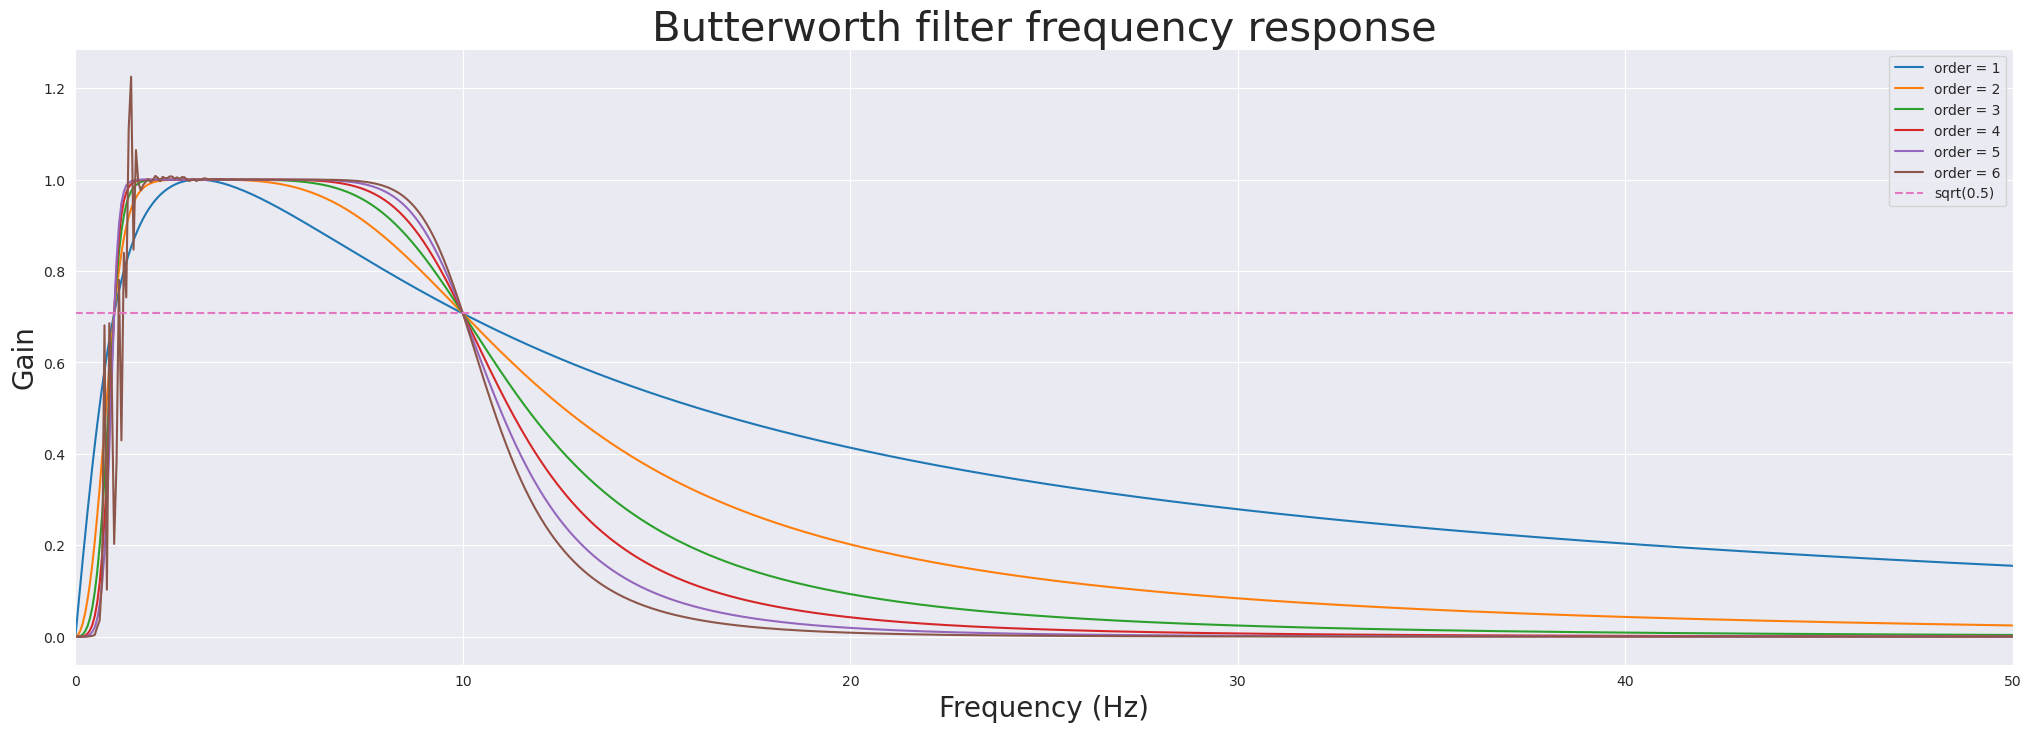

In [12]:
low = 1
high = 10
fs = 250
# Frequency response
plt.figure(1, figsize=(25, 8))
plt.clf()
for order in [1, 2, 3, 4, 5, 6]:
    b, a = butter_bandpass(low, high, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.title("Butterworth filter frequency response", fontsize=30)
plt.xlabel('Frequency (Hz)', fontsize=20)
plt.xlim([0, 50])
plt.ylabel('Gain', fontsize=20)
plt.grid(True)
plt.legend(loc='best')


# Filter data

In [13]:
appX_filt = []
appy_filt = []

start = 0
stop = 1
fs = 250

low = 1
high = 10

for i in range(len(files)-7):
    file = files[i]
    X, Y, Trials, Flash = load_data(file)
    X_clean_filt, y_clean_filt = prepare_data(X, Y, Flash, start, stop, True)
    appX_filt.append(X_clean_filt)
    appy_filt.append(np.array(y_clean_filt))

In [14]:
X_filt = np.array([subject for subject in appX_filt])
y_filt = np.array([np.array(subject) for subject in appy_filt])

X_filt = np.vstack(X_filt)
X_filt = X_filt.reshape(X_filt.shape[0], int(X_filt.shape[1]/fs), int(X_filt.shape[1]/len(channels)))
y_filt = y_filt.reshape(y_filt.shape[0]*y_filt.shape[1])

print(X_filt.shape, y_filt.shape)

(1360, 8, 250) (1360,)


In [15]:
# Xdawn is used as a preprocessing measure to make the data cleaner

def xdawn_results(model, data, label):
    n_filter = 15
    clf = make_pipeline(Xdawn(n_components=n_filter),
                        Vectorizer(),
                        StandardScaler(),
                        model)

    # Cross validator
    cv = StratifiedKFold(n_splits=4, shuffle=True)

    # Do cross-validation
    preds = np.empty(len(label))
    for train, test in cv.split(data, label):
        clf.fit(data[train], label[train])
        preds[test] = clf.predict(data[test])
        
#     # Classification report
#     target_names = ['1', '0']
#     report = classification_report(y, preds, target_names=target_names)
#     print(report)
    
    # Confusion matrix
    cm = metrics.confusion_matrix(y, preds)
    acc = (cm[0][0] + cm[1][1])/sum(sum(cm))

#     # Plot confusion matrix
#     plt.figure(figsize=(9,9))
#     sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
#     plt.ylabel('Actual label');
#     plt.xlabel('Predicted label');
#     all_sample_title = 'Accuracy Score: {1}'.format("Some model", acc)
#     plt.title(all_sample_title, size = 15);
    
    return acc, cm

In [16]:
def classifier_results(model, data, label):
    cm = metrics.confusion_matrix(y, cross_val_predict(model, 
                                                       data.reshape(data.shape[0], data.shape[1]*data.shape[2]), 
                                                       y, 
                                                       cv=StratifiedKFold(5, shuffle=True)))

    acc = (cm[0][0] + cm[1][1])/sum(sum(cm))

#     # Plot confusion matrix
#     plt.figure(figsize=(9,9))
#     sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
#     plt.ylabel('Actual label');
#     plt.xlabel('Predicted label');
#     all_sample_title = 'Accuracy Score: {1}'.format("Some model", acc)
#     plt.title(all_sample_title, size = 15);
    
    return acc, cm

In [17]:
# Write function to see the results from everyone individually
from tqdm import tqdm

def inter_patient_results(model, data, label, xdawn_boo, filter_boo):
    start = 0
    stop = 1
    fs = 250
    
    acc_all = []
    cm_all = []
    
    for i in tqdm(range(len(files))):
        file = files[i]
        appX = []
        appy = []
    
        X, Y, Trials, Flash = load_data(file)
        X_clean, y_clean = prepare_data(X, Y, Flash, start, stop, filter_boo)
        appX.append(X_clean)
        appy.append(np.array(y_clean))
        
        X = np.array([subject for subject in appX])
        y = np.array([np.array(subject) for subject in appy])

        X = np.vstack(X)
        X = X.reshape(X.shape[0], int(X.shape[1]/fs), int(X.shape[1]/len(channels)))
        y = y.reshape(y.shape[0]*y.shape[1])

#         print(X.shape, y.shape)
        
        if xdawn_boo:
            info = mne.create_info(channels, fs, 'eeg')
            info.set_montage('standard_1020')
            X_mne = mne.EpochsArray(X, info)
            
            acc, cm = xdawn_results(model, X_mne, y)
            acc_all.append(acc)
            cm_all.append(cm)
        else:
            acc, cm = classifier_results(model, X, y)
            acc_all.append(acc)
            cm_all.append(cm)
        
    return acc_all, cm_all

In [ ]:
LDA_acc, LDA_cm = inter_patient_results(LDA(shrinkage='auto', solver='eigen'), X, y, False, False)

In [ ]:
LDA_xdawn_acc, LDA_xdawn_cm = inter_patient_results(LDA(shrinkage='auto', solver='eigen'), X, y, True, False)

In [ ]:
svm_acc, svm_cm = inter_patient_results(SVC(kernel='rbf'), X, y, False, False)

In [ ]:
svm_xdawn_acc, svm_xdawn_cm = inter_patient_results(SVC(kernel='rbf'), X, y, True, False)

In [ ]:
rf_acc, rf_cm = inter_patient_results(RandomForestClassifier(300), X, y, False, False)

In [ ]:
rf_xdawn_acc, rf_xdawn_cm = inter_patient_results(RandomForestClassifier(300), X, y, True, False)

In [ ]:
LDA_acc_filt, LDA_cm_filt = inter_patient_results(LDA(shrinkage='auto', solver='eigen'), X_filt, y, False, True)

In [ ]:
LDA_xdawn_acc_filt, LDA_xdawn_cm_filt = inter_patient_results(LDA(shrinkage='auto', solver='eigen'), X_filt, y, True, True)

In [ ]:
svm_acc_filt, svm_cm_filt = inter_patient_results(SVC(kernel='rbf'), X_filt, y, False, True)

In [ ]:
svm_xdawn_acc_filt, svm_xdawn_cm_filt = inter_patient_results(SVC(kernel='rbf'), X_filt, y, True, True)

In [ ]:
rf_acc_filt, rf_cm_filt = inter_patient_results(RandomForestClassifier(300), X_filt, y, False, True)

In [ ]:
rf_xdawn_acc_filt, rf_xdawn_cm_filt = inter_patient_results(RandomForestClassifier(300), X_filt, y, True, True)

# What is the performance like without xdawn and without filtering?

In [ ]:
patients = [int(i[-5]) for i in files]

Z = [x for _,x in sorted(zip(patients, svm_acc))]
line1, = plt.plot(sorted(patients), Z, label="svm", marker='o')

Z = [x for _,x in sorted(zip(patients, LDA_acc))]
line2, = plt.plot(sorted(patients), Z, label="LDA", marker='o')

Z = [x for _,x in sorted(zip(patients, rf_acc))]
line3, = plt.plot(sorted(patients), Z, label="rf", marker='o')

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('All without xdawn')
plt.xlabel('Patient ID')
plt.ylabel('Accuracy')
plt.show()

# What is the performance like with xdawn and without filtering?

In [ ]:
patients = [int(i[-5]) for i in files]

Z = [x for _,x in sorted(zip(patients, svm_xdawn_acc))]
line1, = plt.plot(sorted(patients), Z, label="svm", marker='o')

Z = [x for _,x in sorted(zip(patients, LDA_xdawn_acc))]
line2, = plt.plot(sorted(patients), Z, label="LDA", marker='o')

Z = [x for _,x in sorted(zip(patients, rf_xdawn_acc))]
line3, = plt.plot(sorted(patients), Z, label="rf", marker='o')

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('All with xdawn')
plt.xlabel('Patient ID')
plt.ylabel('Accuracy')
plt.show()

# What is the performance like without xdawn and with filtering?

In [ ]:
patients = [int(i[-5]) for i in files]

Z = [x for _,x in sorted(zip(patients, svm_acc_filt))]
line1, = plt.plot(sorted(patients), Z, label="svm", marker='o')

Z = [x for _,x in sorted(zip(patients, LDA_acc_filt))]
line2, = plt.plot(sorted(patients), Z, label="LDA", marker='o')

Z = [x for _,x in sorted(zip(patients, rf_acc_filt))]
line3, = plt.plot(sorted(patients), Z, label="rf", marker='o')

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('All without xdawn and filtered')
plt.xlabel('Patient ID')
plt.ylabel('Accuracy')
plt.show()

# What is the performance like with xdawn and with filtering?

In [ ]:
patients = [int(i[-5]) for i in files]

Z = [x for _,x in sorted(zip(patients, svm_xdawn_acc_filt))]
line1, = plt.plot(sorted(patients), Z, label="svm", marker='o')

Z = [x for _,x in sorted(zip(patients, LDA_xdawn_acc_filt))]
line2, = plt.plot(sorted(patients), Z, label="LDA", marker='o')

Z = [x for _,x in sorted(zip(patients, rf_xdawn_acc_filt))]
line3, = plt.plot(sorted(patients), Z, label="rf", marker='o')

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('All with xdawn and filtered')
plt.xlabel('Patient ID')
plt.ylabel('Accuracy')
plt.show()

# Effects of filtering and xdawn
Some people had minor effects, but in general we see an improvement in accuracy when using filtered data and xdawn to preprocess the information

# Actually seeing if we get the letters right

In [ ]:
appX_nonUS = []
appy_nonUS = []

start = 0
stop = 1
fs = 250

for i in range(len(files)-7): # one file for now
    file = files[i]
    X, Y, Trials, Flash = load_data(file)

    X_clean_nonUS, y_clean_nonUS = prepare_data_nonUS(X, Y, Flash, start, stop)
    appX_nonUS.append(X_clean_nonUS)
    appy_nonUS.append(np.array(y_clean_nonUS))

In [ ]:
# X = np.array([subject for subject in appX]) # 1360 flashes of 2000 samples
# y = np.array([np.array(subject) for subject in appy])
# X = np.vstack(X) 
# X = X.reshape(X.shape[0], int(X.shape[1]/fs), int(X.shape[1]/len(channels))) # reshape into 8 channels of 250 = 2000
# y = y.reshape(y.shape[0]*y.shape[1])
# print("Undersampled data: ", X.shape, y.shape)


X_nonUS = np.array([subject for subject in appX_nonUS]) # 1360 flashes of 2000 samples
y_nonUS = np.array([np.array(subject) for subject in appy_nonUS])
X_nonUS = np.vstack(X_nonUS) #put 
X_nonUS = X_nonUS.reshape(X_nonUS.shape[0], int(X_nonUS.shape[1]/fs), int(X_nonUS.shape[1]/len(channels))) # reshape into 8 channels of 250 = 2000
y_nonUS = y_nonUS.reshape(y_nonUS.shape[0]*y_nonUS.shape[1])
print("Non undersampled data: ", X_nonUS.shape, y_nonUS.shape)

In [ ]:
# Setup mne so we can use xdawn directly in a pipeline
info = mne.create_info(channels, fs, 'eeg')
info.set_montage('standard_1020')
# X_mne = mne.EpochsArray(X, info)
X_nonUS_mne = mne.EpochsArray(X_nonUS, info)

n_filter = 15 # the more filters the better, but longer
clf = make_pipeline(Xdawn(n_components=n_filter),
                    Vectorizer(),
                    StandardScaler(),
                    LDA(shrinkage='auto', solver='eigen')) # model here

# Cross validator
cv = KFold(n_splits=34) # This splits the data to train on 33 letters and test on one!

# Do cross-validation
preds = np.empty(len(y_nonUS))
for train, test in cv.split(X_nonUS_mne, y_nonUS):
    clf.fit(X_nonUS_mne[train], y_nonUS[train])
    preds[test] = clf.predict(X_nonUS_mne[test])


In [ ]:
preds_set_hit = np.zeros(4080//12)

for i in range(12):
    rows = preds[i::12]
    preds_set_hit = np.vstack((preds_set_hit, rows))
print(np.shape(preds_set_hit))
plt.hist(sum(preds_set_hit[1:,:]))
preds_set_hit = np.transpose(preds_set_hit[1:,:])
print(np.shape(preds_set_hit))
print(preds_set_hit[0:10])

In [ ]:
id_seq = [each[2] for each in Flash]
set_seq = np.zeros(4200//12)
for i in range(12):
    rows = id_seq[i::12]
    set_seq = np.vstack((set_seq, rows))

set_seq = np.transpose(set_seq[1:,:])


hit_seq = [each[3]-1 for each in Flash]
set_hit = np.zeros(4200//12)
for i in range(12):
    rows = hit_seq[i::12]
    set_hit = np.vstack((set_hit, rows))

plt.hist(sum(set_hit[1:,:]))
set_hit = np.transpose(set_hit[1:,:])
print(set_hit[0:10])

In [ ]:
# set_hit
# preds_set_hit
print(len(set_hit))
print(len(preds_set_hit))
scores = []
for truth,guess in zip(set_hit[:340], preds_set_hit[:340]):
    num_correct = np.sum(truth + guess == 2)
    num_incorrect = np.sum(guess == 1) - num_correct
    scores += [[num_correct, num_incorrect]]


In [ ]:
print(np.mean(np.array(scores)[:,0])/2)
plt.hist(np.array(scores)[:,0])

In [ ]:
print(np.mean(np.array(scores)[:,1]))
plt.hist(np.array(scores)[:,1])

In [ ]:
print(set_seq[0][set_hit[0]==1])
set_coords = [seq_i[hit_i==1] for seq_i,hit_i in zip(set_seq, set_hit)]
print(set_coords[0:5])
print(np.size(set_coords))
for i in range(len(set_coords)):
    if set_coords[i][0] > 6:
        set_coords[i] = np.array([set_coords[i][1], set_coords[i][0]])
set_coords=np.array(set_coords)
print(set_coords[0:20])
print(np.size(set_coords)) # 700 entries of 2
plt.hist(set_coords, bins = 12)

In [ ]:
# print(set_seq[0][set_hit[0]==1])
preds_set_coords = [seq_i[hit_i==1] for seq_i,hit_i in zip(set_seq, preds_set_hit)]
# print(preds_set_coords[0:5])
print(np.size(set_coords))
# for i in range(len(set_coords)):
#   if set_coords[i][0] > 6:
#     set_coords[i] = np.array([set_coords[i][1], set_coords[i][0]])
preds_set_coords=np.array(preds_set_coords)
print(preds_set_coords[0:20])
# print(np.size(set_coords)) # 700 entries of 2
# plt.hist(preds_set_coords[0:10], bins = 12)
plt.hist([elt for lst in preds_set_coords[0:10] for elt in lst], bins=12)

In [ ]:
# can select tallest two?
plt.hist([elt for lst in preds_set_coords[10:20] for elt in lst], bins=12)
print(set_coords[10])

In [ ]:
letter_id = 3
plt.hist([elt for lst in preds_set_coords[letter_id*10:letter_id*10+10] for elt in lst], bins=12)
print(set_coords[letter_id*10])

In [ ]:
# letter_id = 3
# [elt for lst in preds_set_coords[letter_id*10:letter_id*10+10] for elt in lst]
# import pandas.DataFrame as df
# df['column'].value_counts()

df = pd.DataFrame([elt for lst in preds_set_coords[letter_id*10:letter_id*10+10] for elt in lst])
print(df.value_counts())
print(type(df.value_counts()))
list(df.value_counts())
# np.array(df.value_counts())
df.value_counts().index.tolist()

In [ ]:
preds_set_coords2 = np.array([0,0])
true_set_coords2 = np.array([0,0])
for letter_id in range(34):
    modes = pd.DataFrame([elt for lst in preds_set_coords[letter_id*10:letter_id*10+10] for elt in lst]).value_counts().index.tolist()
    # print(modes[0][0])
    # print(modes[1][0])
    # print([modes[0], modes[1]])
    preds_set_coords2 = np.vstack((preds_set_coords2, [modes[0][0], modes[1][0]]))
    true_set_coords2 = np.vstack( (true_set_coords2, set_coords[letter_id*10]))
for i in range(len(preds_set_coords2)):
    if preds_set_coords2[i][0] > 6:
        preds_set_coords2[i] = np.array([preds_set_coords2[i][1], preds_set_coords2[i][0]])

In [ ]:
# print(preds_set_coords2)
# print(true_set_coords2)
row_col_boo = (preds_set_coords2 == true_set_coords2)

letter_acc_count = 0
for i in range(row_col_boo.shape[0]):
    if (row_col_boo[i] == True).all():
        letter_acc_count += 1

print(letter_acc_count/row_col_boo.shape[0])

# Apply to every participant

In [ ]:
appX_nonUS = []
appy_nonUS = []

start = 0
stop = 1
fs = 250

performance_results = []

for i in range(len(files)): # ALL files now
    # REMOVE FOR PROPER ITER
    appX = []
    appy = []
    appX_nonUS = []
    appy_nonUS = []
    #

    file = files[i]
    X, Y, Trials, Flash = load_data(file)

    X_clean_nonUS, y_clean_nonUS = prepare_data_nonUS(X, Y, Flash, start, stop)
    appX_nonUS.append(X_clean_nonUS)
    appy_nonUS.append(np.array(y_clean_nonUS))

    X_nonUS = np.array([subject for subject in appX_nonUS]) # 1360 flashes of 2000 samples
    y_nonUS = np.array([np.array(subject) for subject in appy_nonUS])
    X_nonUS = np.vstack(X_nonUS) #put 
    X_nonUS = X_nonUS.reshape(X_nonUS.shape[0], int(X_nonUS.shape[1]/fs), int(X_nonUS.shape[1]/len(channels))) # reshape into 8 channels of 250 = 2000
    y_nonUS = y_nonUS.reshape(y_nonUS.shape[0]*y_nonUS.shape[1])
    print(X_nonUS.shape, y_nonUS.shape)

    ######
    # X, X_nonUS, y, Flash

    info = mne.create_info(channels, fs, 'eeg')
    info.set_montage('standard_1020')
    X_nonUS_mne = mne.EpochsArray(X_nonUS, info)

    # acc, cm = xdawn_results(model, X_mne, y)

    n_filter = 15 # the more filters the better, but longer
    clf = make_pipeline(Xdawn(n_components=n_filter),
                        Vectorizer(),
                        StandardScaler(),
                        LDA(shrinkage='auto', solver='eigen')) # model here

    # Cross validator
    cv = KFold(n_splits=34)

    # Do cross-validation
    preds = np.empty(len(y_nonUS))
    for train, test in cv.split(X_nonUS_mne, y_nonUS):
        clf.fit(X_nonUS_mne[train], y_nonUS[train]) # taking long here
        preds[test] = clf.predict(X_nonUS_mne[test])

    # -> preds_nonUS -> preds_set_hit [GUESS]
    preds_set_hit = np.zeros(4080//12)
    for i in range(12):
        rows = preds[i::12]
        preds_set_hit = np.vstack((preds_set_hit, rows))
    preds_set_hit = np.transpose(preds_set_hit[1:,:])

    ## set_seq -> set_hit [TRUTH]
    id_seq = [each[2] for each in Flash]
    set_seq = np.zeros(4200//12)
    for i in range(12):
        rows = id_seq[i::12]
        set_seq = np.vstack((set_seq, rows))
    set_seq = np.transpose(set_seq[1:,:])
    ##
    hit_seq = [each[3]-1 for each in Flash]
    set_hit = np.zeros(4200//12)
    for i in range(12):
        rows = hit_seq[i::12]
        set_hit = np.vstack((set_hit, rows))
    set_hit = np.transpose(set_hit[1:,:])



    ####
    scores = []
    for truth,guess in zip(set_hit[:340], preds_set_hit[:340]):
        num_correct = np.sum(truth + guess == 2)
        num_incorrect = np.sum(guess == 1) - num_correct
        scores += [[num_correct, num_incorrect]]


    # set_seq, preds_set_hit
    preds_set_coords = [seq_i[hit_i==1] for seq_i,hit_i in zip(set_seq, preds_set_hit)]
    preds_set_coords=np.array(preds_set_coords)

    preds_set_coords2 = np.array([0,0])
    true_set_coords2 = np.array([0,0])
    for letter_id in range(34):
        modes = pd.DataFrame([elt for lst in preds_set_coords[letter_id*10:letter_id*10+10] for elt in lst]).value_counts().index.tolist()
        preds_set_coords2 = np.vstack((preds_set_coords2, [modes[0][0], modes[1][0]]))
        true_set_coords2 = np.vstack( (true_set_coords2, set_coords[letter_id*10]))
    for i in range(len(preds_set_coords2)):
        if preds_set_coords2[i][0] > 6:
            preds_set_coords2[i] = np.array([preds_set_coords2[i][1], preds_set_coords2[i][0]])

    # print(np.sum(preds_set_coords2 == true_set_coords2)/np.size(preds_set_coords2 == true_set_coords2))
    row_col_boo = (preds_set_coords2 == true_set_coords2)
    letter_acc_count = 0
    for i in range(row_col_boo.shape[0]):
        if (row_col_boo[i] == True).all():
            letter_acc_count += 1

    print(letter_acc_count/row_col_boo.shape[0])
    
#     performance_results += [np.sum(preds_set_coords2 == true_set_coords2)/np.size(preds_set_coords2 == true_set_coords2)]
    performance_results += [letter_acc_count/row_col_boo.shape[0]]

print(performance_results)

In [ ]:
plt.figure(figsize=(10,7))
plt.bar(sorted(patients), 
        [round(i*100,2) for i in performance_results], 
        color=['red', 'orange', 'yellow', 'green', 'blue', 'cyan', 'magenta', 'brown'])
plt.title("Participant accuracies", fontsize=30)
plt.xlabel("Patient ID", fontsize=20)
plt.ylabel("Individual letter accuracy (%)", fontsize=20)
plt.axhline(y=100, color='grey', linestyle='--', linewidth=5)
plt.axhline(y=int(1*100/36), color='grey', linestyle='--', linewidth=5) # Chance level!
plt.ylim([0,110])
plt.show()

# Conclusion

Due to the fact they repeate each word stimulus 10 times we can reach a relatively high accuracy with some participants. 
Naturally, with BCI we expect huge inter-participant variation in performance. 

Thank you to Brandon Chen for his contribution in producing the code for back tracking rows and columns. 